In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf

import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torch.nn.functional as func 

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

time: 1.19 ms (started: 2022-12-20 11:57:02 +00:00)


# Download data in kaggle input

In [13]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

# install utils

In [2]:
!pip install ipython-autotime

%load_ext autotime

time: 445 µs (started: 2022-12-20 11:12:08 +00:00)


## check GPU

In [6]:
# # check if CUDA is available
# train_on_gpu = torch.cuda.is_available()

# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')
    
# device_num = 0
# device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

# print(f"Device: {device}")

CUDA is available!  Training on GPU ...
Device: cuda:0


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8635874954845955193
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16149905408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12325637773842668144
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
time: 4.63 ms (started: 2022-12-20 11:12:15 +00:00)


2022-12-20 11:12:15.564175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:12:15.565208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:12:15.565852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:12:15.566543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:12:15.567206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1
time: 3.33 ms (started: 2022-12-20 11:18:11 +00:00)


2022-12-20 11:18:11.055655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:18:11.056583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:18:11.057238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Описание датасета

Aligned&Cropped Faces

Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

# 1.Load Data

In [12]:
! ls -a

.  ..  .virtual_documents  __notebook_source__.ipynb
time: 1.13 s (started: 2022-12-20 11:20:09 +00:00)


In [18]:
#    /kaggle/input/utkface-new/crop_part1/65_1_0_20170110182002744.jpg.chip.jpg

path = "/kaggle/input/utkface-new/crop_part1/"

images = []
ages = []
genders = []

for i in os.listdir(path)[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open(path + i))

time: 31.9 s (started: 2022-12-20 11:32:13 +00:00)


всего файлов в датасете crop_part1.

In [19]:
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 9780
26_0_2_20170104023102422.jpg.chip.jpg
time: 5.75 ms (started: 2022-12-20 11:33:31 +00:00)


In [20]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

Images  Ages  Genders
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...    26        0
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...    21        1
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...    17        1
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...    76        0
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...    18        1
...                                                 ...   ...      ...
7995  <PIL.JpegImagePlugin.JpegImageFile image mode=...     3        0
7996  <PIL.JpegImagePlugin.JpegImageFile image mode=...    28        0
7997  <PIL.JpegImagePlugin.JpegImageFile image mode=...    10        0
7998  <PIL.JpegImagePlugin.JpegImageFile image mode=...     8        1
7999  <PIL.JpegImagePlugin.JpegImageFile image mode=...    22        0

[8000 rows x 3 columns]

time: 25.4 s (started: 2022-12-20 11:36:56 +00:00)


In [38]:
def draw_image_from_dataset(filenumber):    
    display(df['Images'][filenumber])
    print('ages - ' + str(df['Ages'][filenumber]),' ---  gender - ' + str(df['Genders'][filenumber]))
    print()

time: 613 µs (started: 2022-12-20 11:45:15 +00:00)


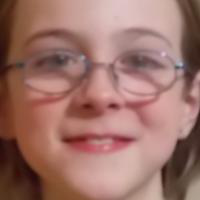

ages - 12  ---  gender - 1

time: 20 ms (started: 2022-12-20 11:45:23 +00:00)


In [39]:
draw_image_from_dataset(5)

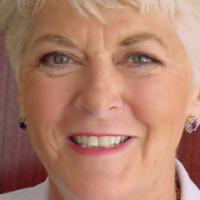

ages - 72  ---  gender - 1

time: 27.7 ms (started: 2022-12-20 11:45:44 +00:00)


In [40]:
draw_image_from_dataset(10)

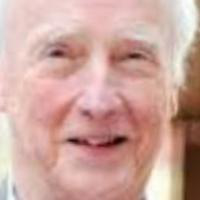

ages - 76  ---  gender - 0

time: 23.1 ms (started: 2022-12-20 11:46:12 +00:00)


In [42]:
draw_image_from_dataset(3)

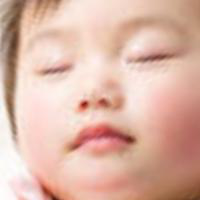

ages - 1  ---  gender - 1

time: 23.2 ms (started: 2022-12-20 11:46:28 +00:00)


In [43]:
draw_image_from_dataset(1005)

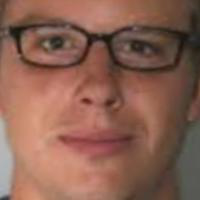

ages - 27  ---  gender - 0

time: 23.2 ms (started: 2022-12-20 11:46:37 +00:00)


In [44]:
draw_image_from_dataset(5005)

**Таким образом, 0 соответствует мужчине, 1 соответствует женщине.**

# 3. Visualisation

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

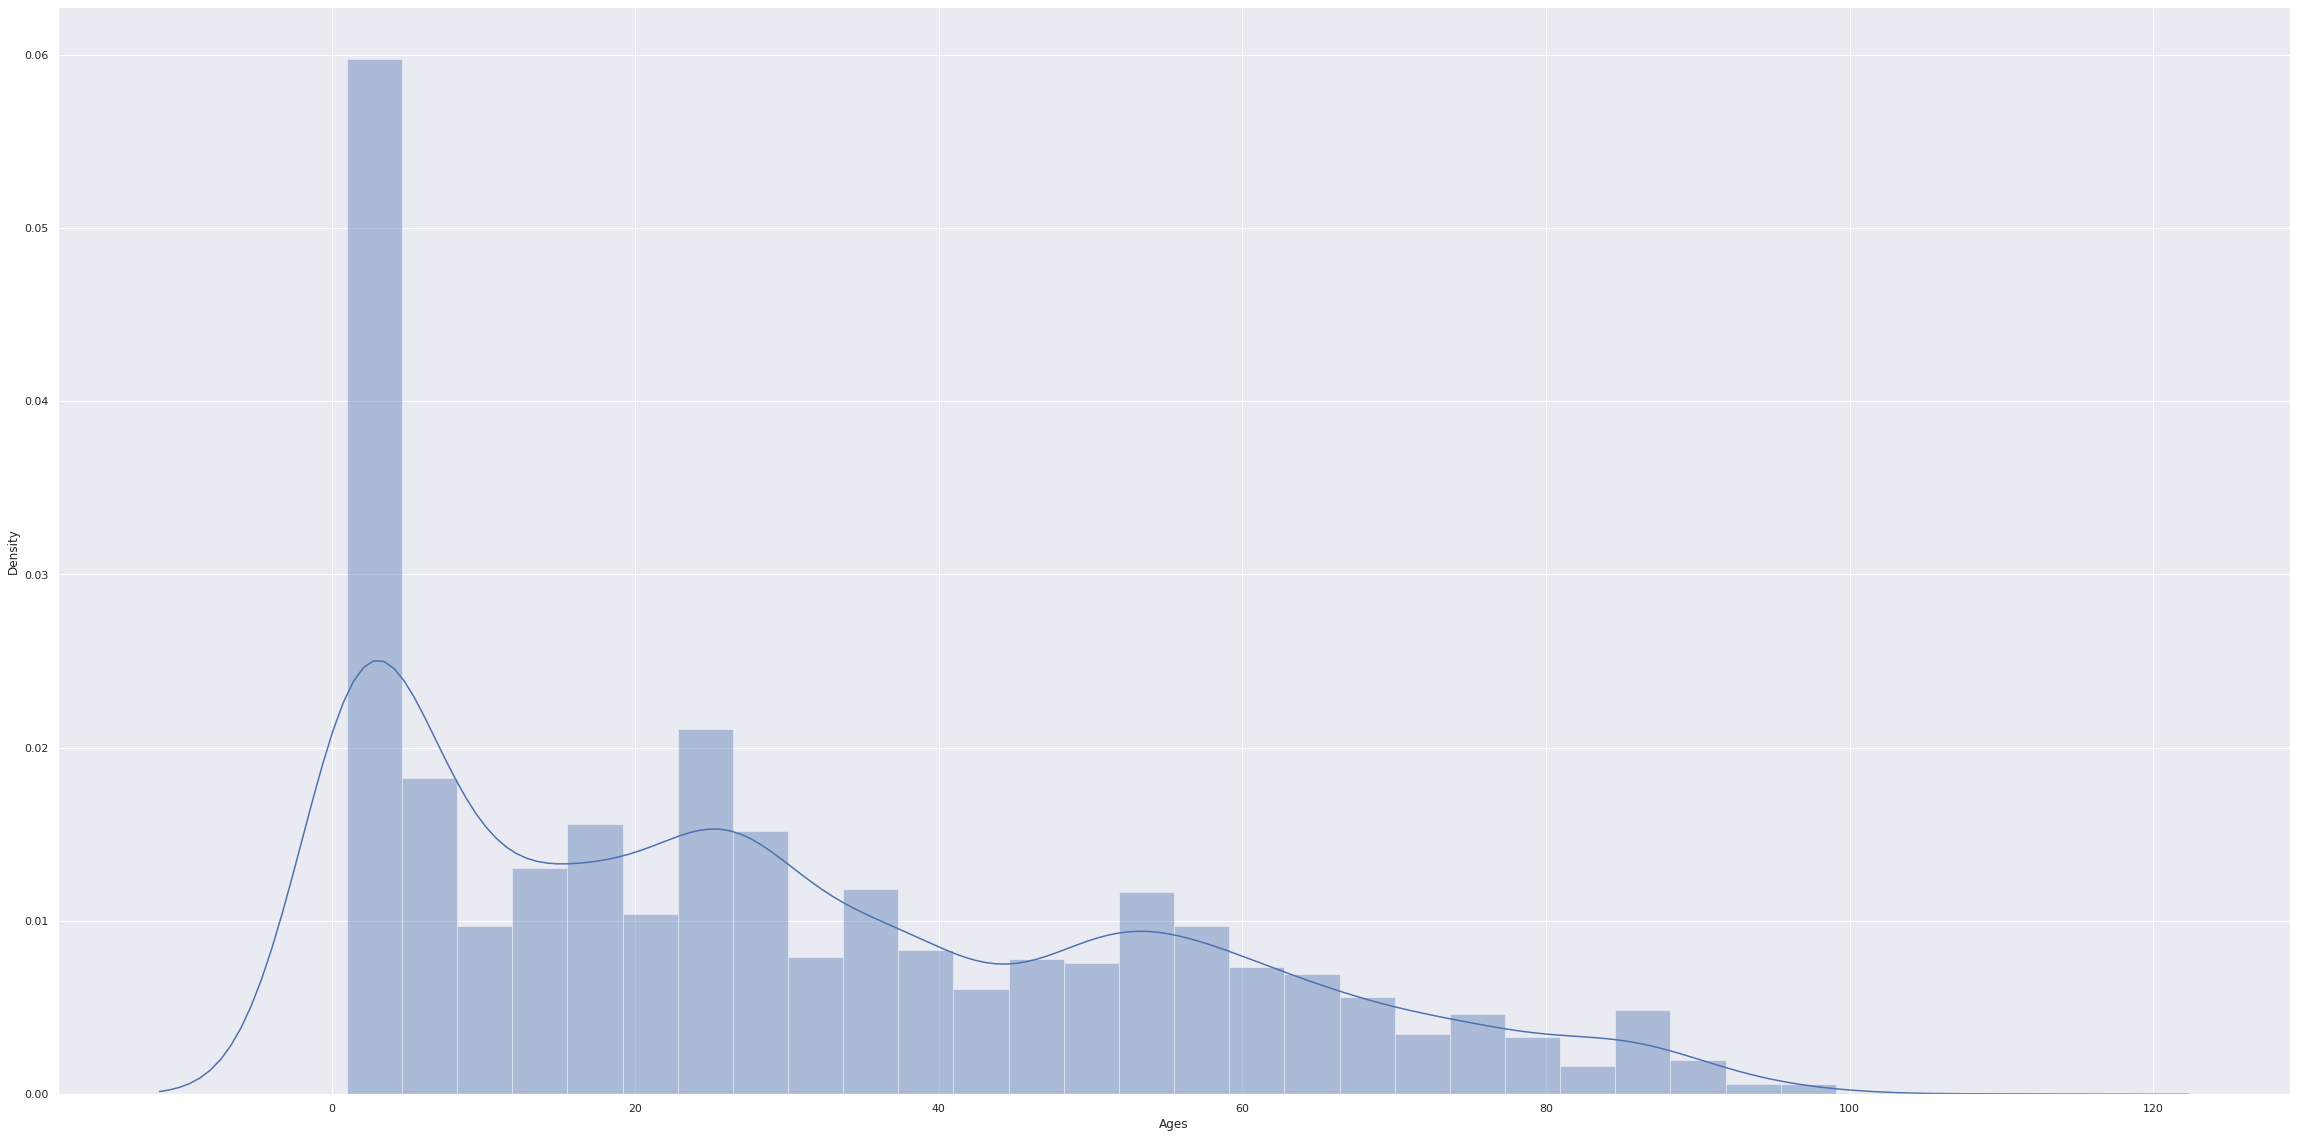

time: 500 ms (started: 2022-12-20 11:49:26 +00:00)


In [50]:
plt.rcParams["figure.figsize"] = (40,20)
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [51]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

time: 301 ms (started: 2022-12-20 11:50:37 +00:00)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

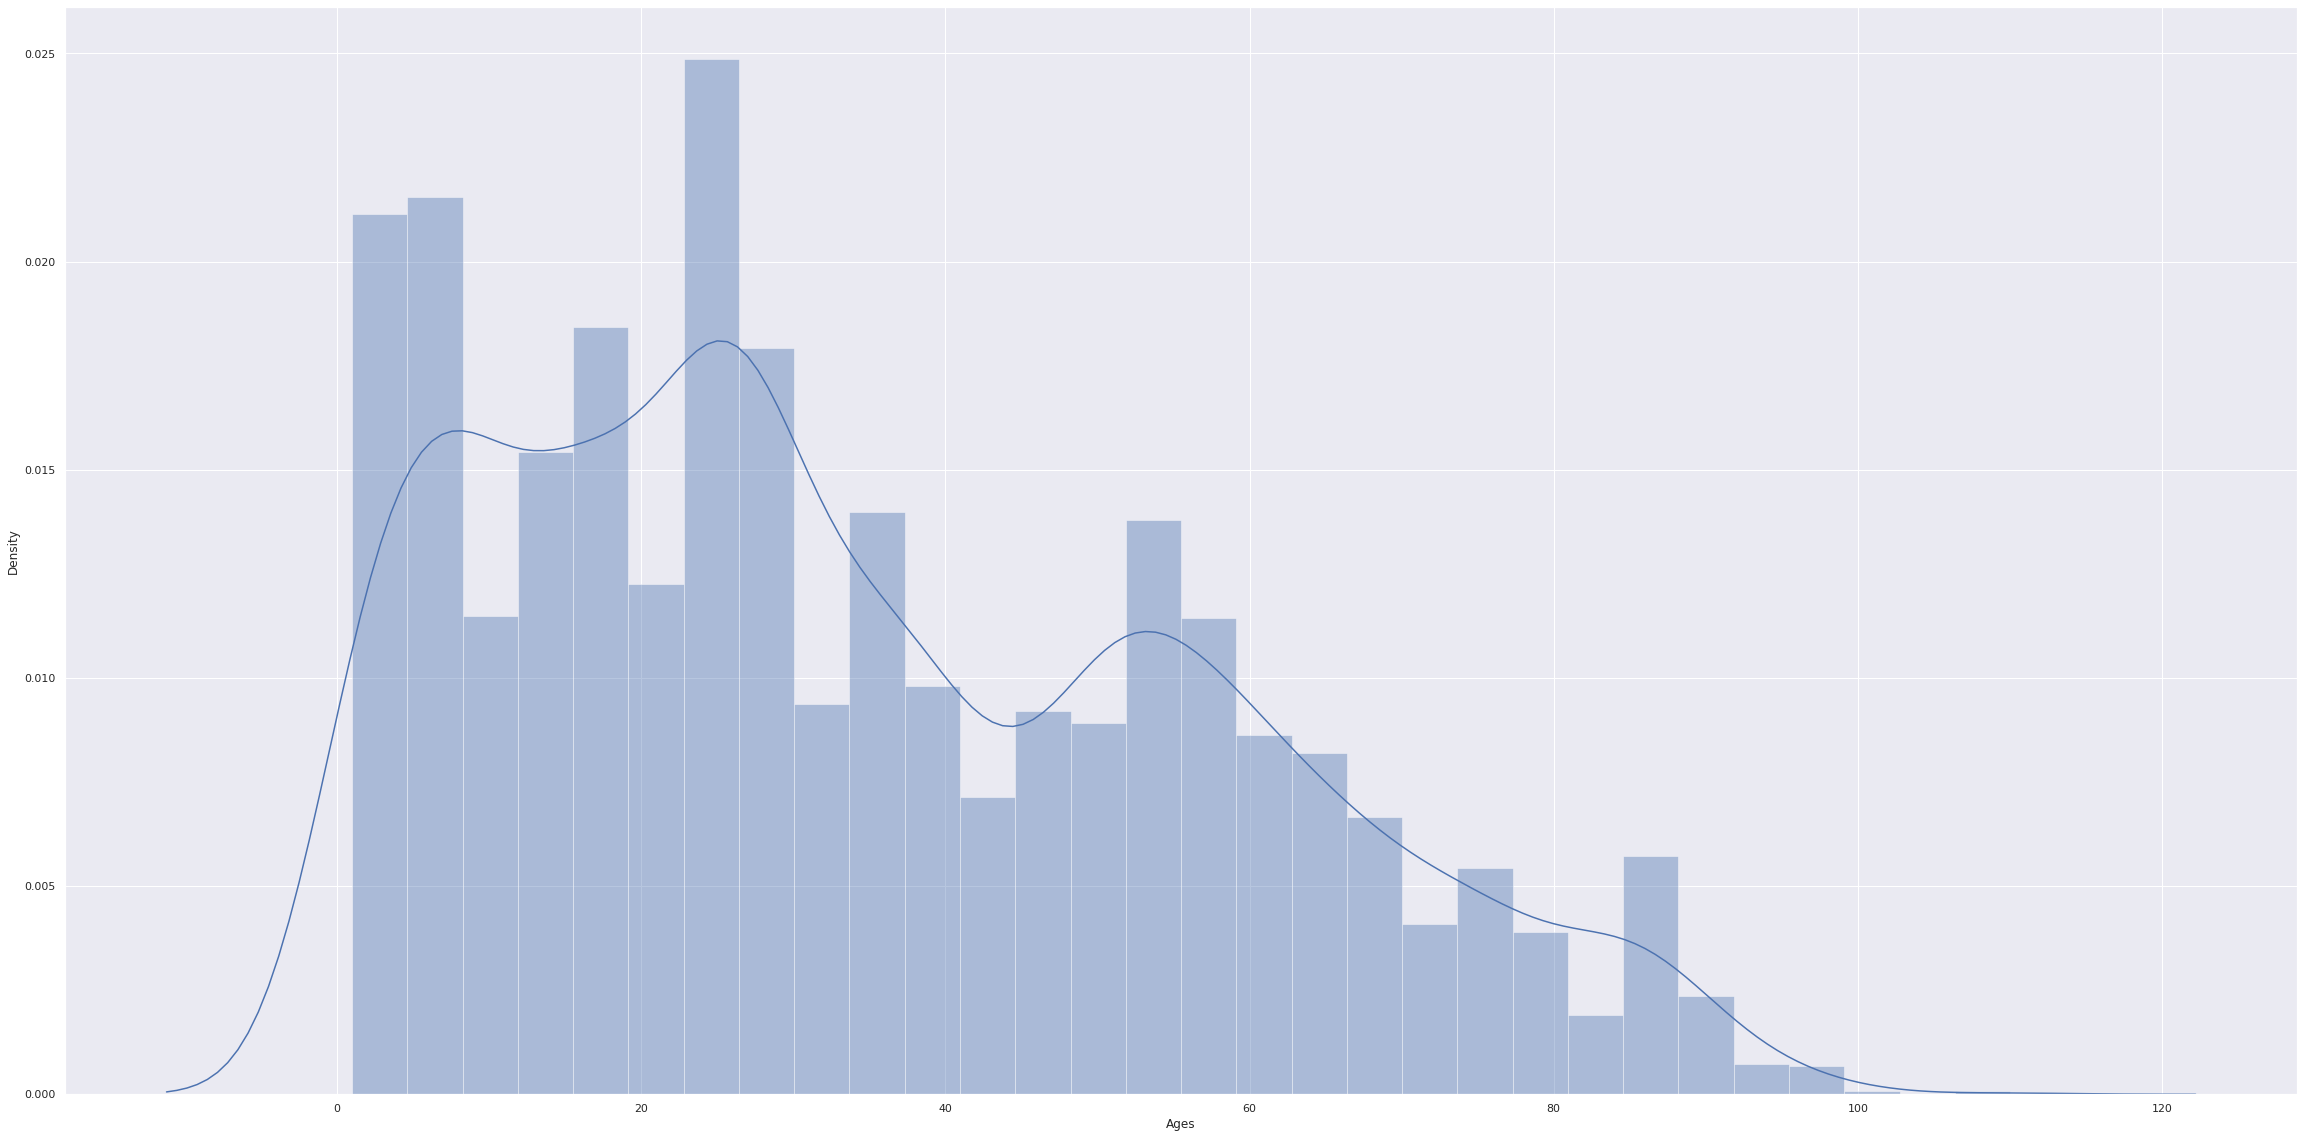

time: 617 ms (started: 2022-12-20 11:50:47 +00:00)


In [52]:
sns.distplot(df['Ages'],kde=True, bins=30)

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

In [53]:
df = df[df['Ages'] < 80]

time: 3.66 ms (started: 2022-12-20 11:51:18 +00:00)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

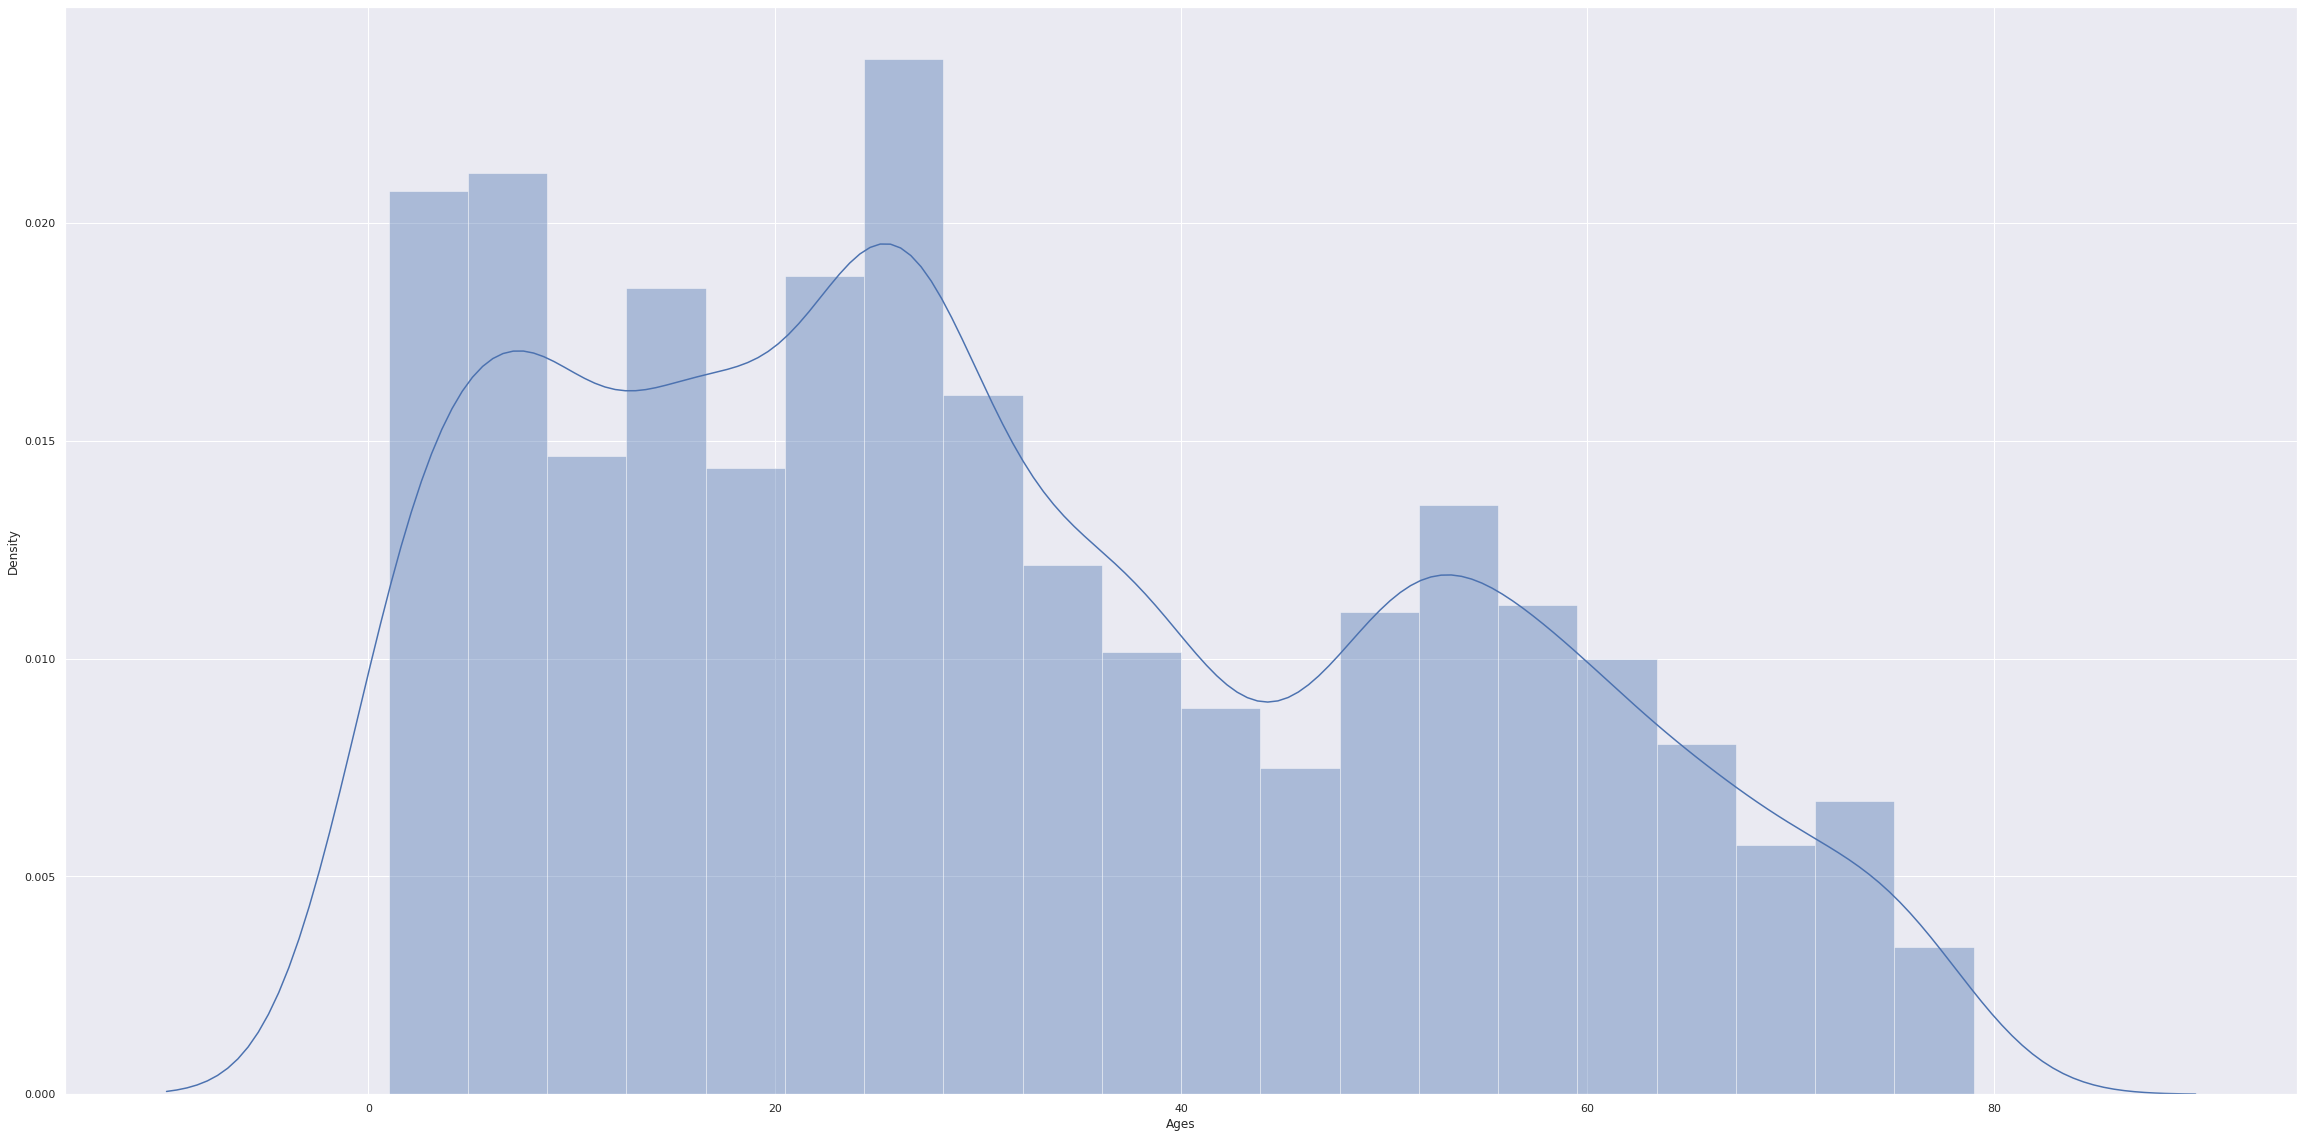

time: 697 ms (started: 2022-12-20 11:51:30 +00:00)


In [54]:
sns.distplot(df['Ages'],kde=True, bins=20)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Genders', ylabel='count'>

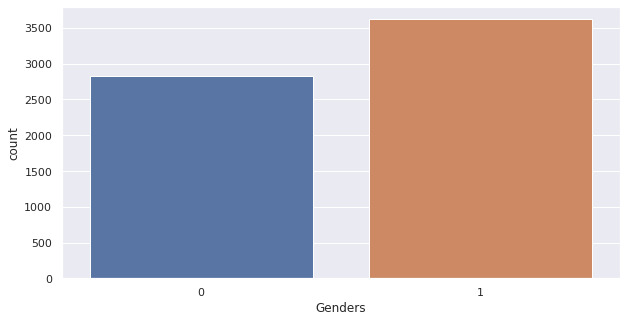

time: 217 ms (started: 2022-12-20 11:52:07 +00:00)


In [56]:
plt.rcParams["figure.figsize"] = (10,5)
sns.countplot(df['Genders'])

Not sure what 3 corresponds to - both genders, no gender, unknown, or just an error in the data entry? To be safe, I am going to remove any rows where gender equals 3.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Genders', ylabel='count'>

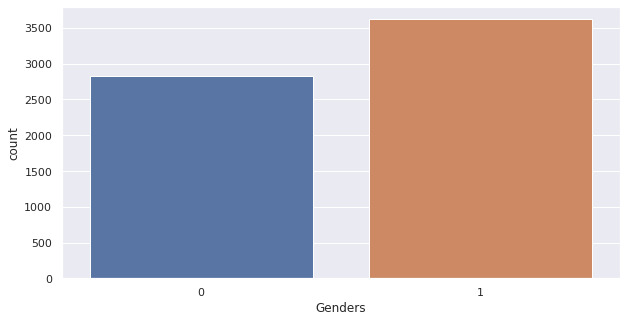

time: 219 ms (started: 2022-12-20 11:52:55 +00:00)


In [57]:
df = df[df['Genders'] != 3]
sns.countplot(df['Genders'])

In [58]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


time: 5.77 s (started: 2022-12-20 11:53:29 +00:00)


# 4. Train Test Split

In [59]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

time: 1.99 s (started: 2022-12-20 11:54:20 +00:00)


# 5. Creating the Models

I will create two individual models - one to predict age and one to predict gender. The age model should be capable of returning continuous values which I will round to the nearest integer, and the gender model should return a binary result.

In [66]:
learning_rate = 0.0001

time: 417 µs (started: 2022-12-20 11:59:18 +00:00)


In [67]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=tf.keras.optimizers.Adam(learning_rate))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate),
             metrics=['accuracy'])

time: 112 ms (started: 2022-12-20 11:59:20 +00:00)


# 6. Training the Models

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

In [7]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
26_0_2_20170104023102422.jpg.chip.jpg


In [8]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

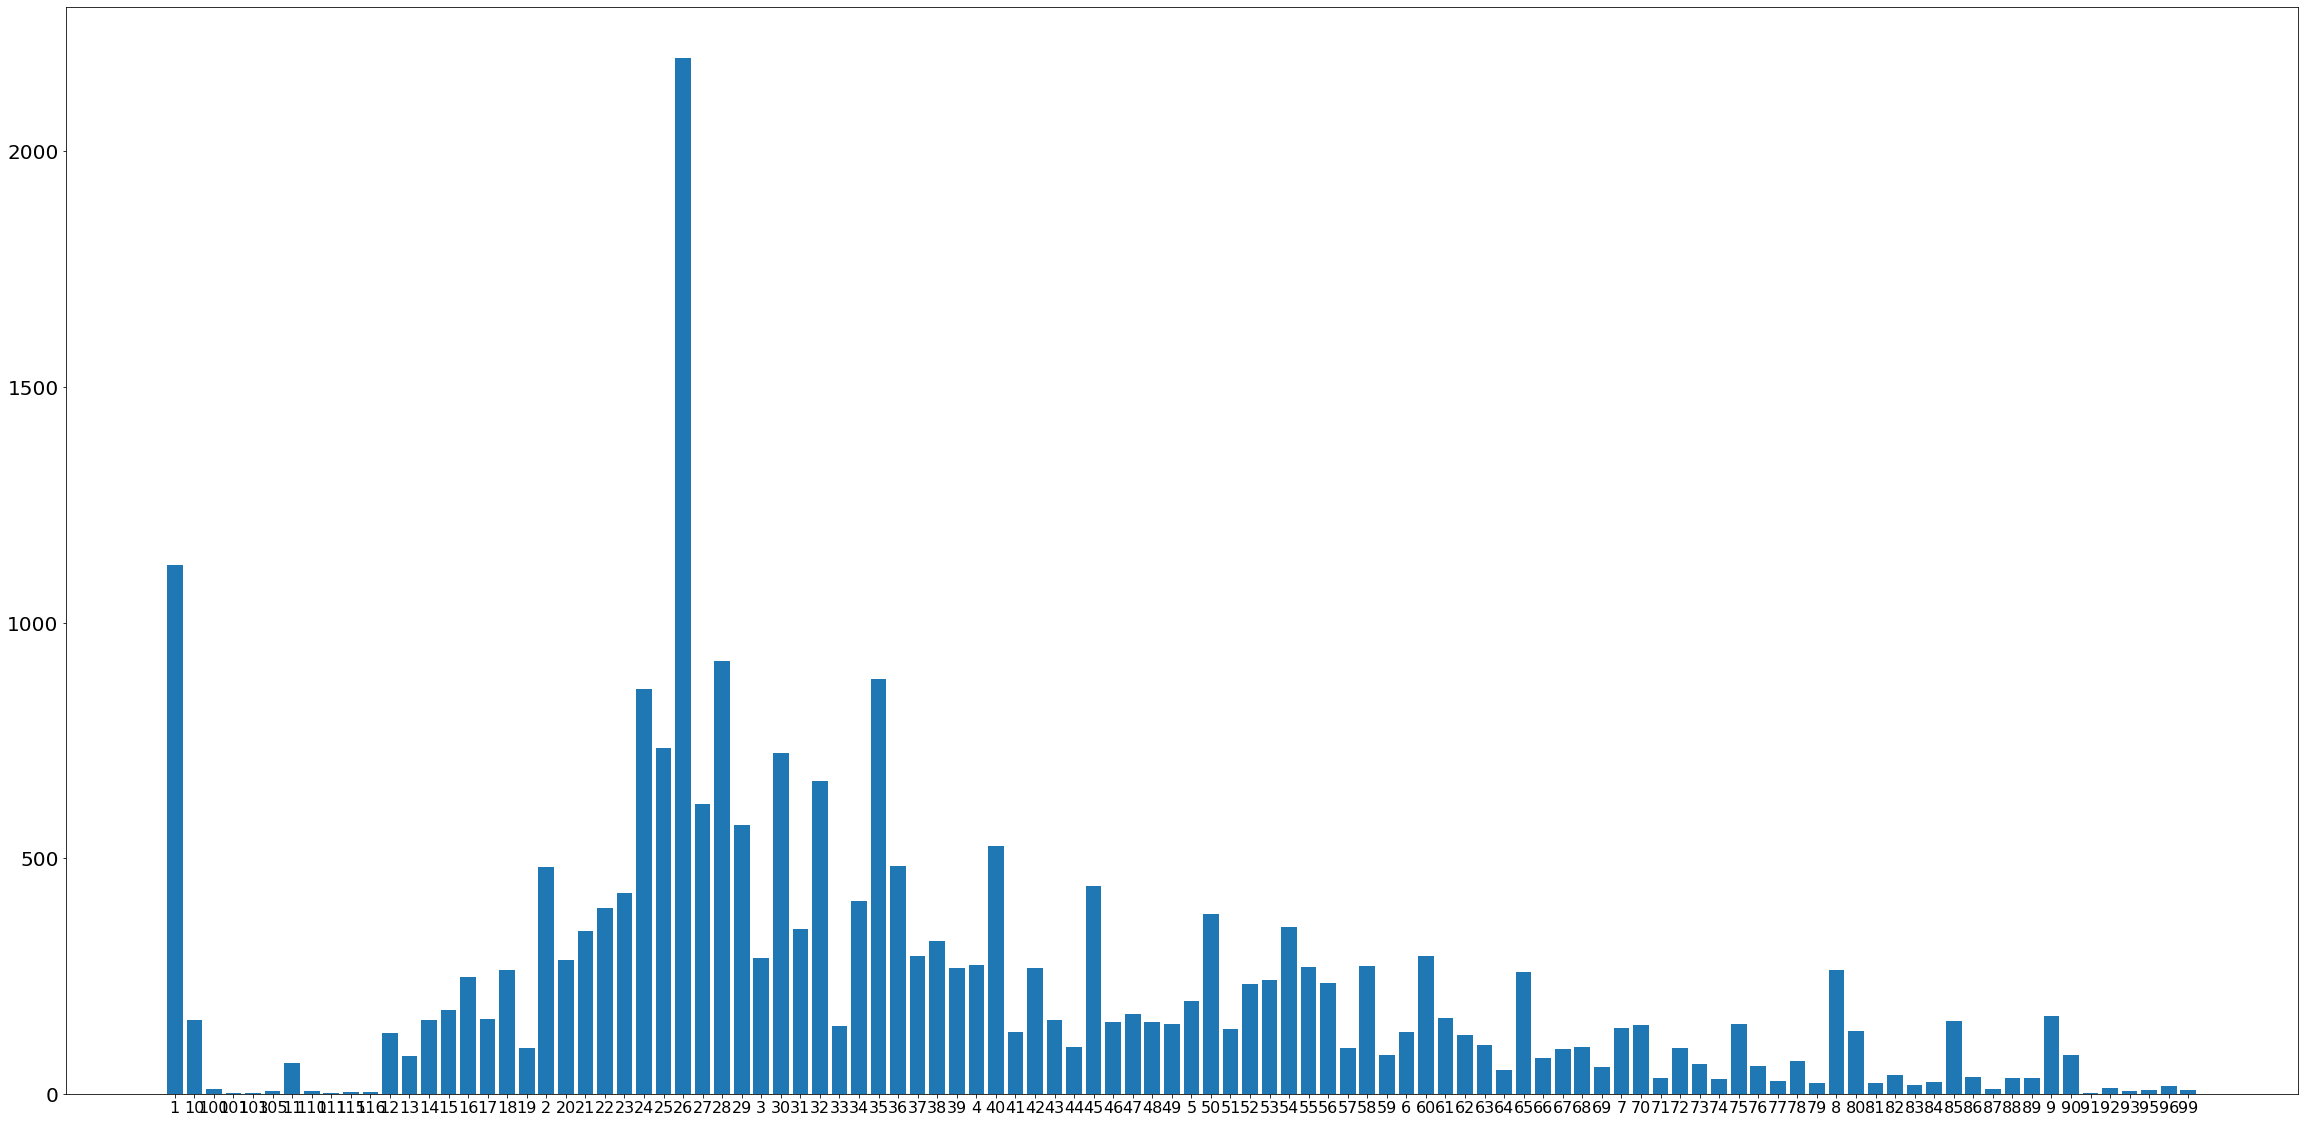

Max value: 99


In [21]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 19})

plt.rcParams["figure.figsize"] = (40,20)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels

x_ages = list(sorted(set(ages)))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: 0 Age: 54


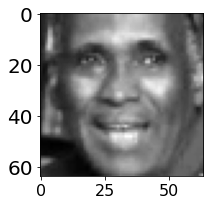

In [22]:
plt.rcParams["figure.figsize"] = (3,3)
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [23]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

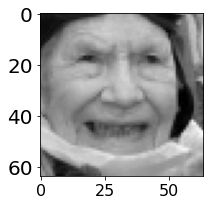

In [24]:
# pre processing

plt.rcParams["figure.figsize"] = (3,3)
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [26]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)


In [27]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

In [35]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

time: 111 ms (started: 2022-12-18 17:15:05 +00:00)


In [36]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])
# if train_on_gpu:
#     model.cuda()

time: 12.7 ms (started: 2022-12-18 17:15:10 +00:00)


In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 62, 62, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 60, 60, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 30, 30, 64)   0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [38]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 25, batch_size=128,shuffle = True)

Epoch 1/25
149/149 [==============================] - 5s 29ms/step - loss: 0.8107 - dense_23_loss: 0.1172 - dense_29_loss: 0.6935 - dense_23_accuracy: 0.0112 - dense_29_accuracy: 0.5276 - val_loss: 0.7225 - val_dense_23_loss: 0.0346 - val_dense_29_loss: 0.6879 - val_dense_23_accuracy: 0.0293 - val_dense_29_accuracy: 0.5816
Epoch 2/25
149/149 [==============================] - 4s 26ms/step - loss: 0.6935 - dense_23_loss: 0.0529 - dense_29_loss: 0.6405 - dense_23_accuracy: 0.0185 - dense_29_accuracy: 0.6766 - val_loss: 0.5648 - val_dense_23_loss: 0.0378 - val_dense_29_loss: 0.5270 - val_dense_23_accuracy: 0.0251 - val_dense_29_accuracy: 0.8003
Epoch 3/25
149/149 [==============================] - 4s 26ms/step - loss: 0.5801 - dense_23_loss: 0.0430 - dense_29_loss: 0.5371 - dense_23_accuracy: 0.0220 - dense_29_accuracy: 0.7699 - val_loss: 0.5023 - val_dense_23_loss: 0.0258 - val_dense_29_loss: 0.4765 - val_dense_23_accuracy: 0.0304 - val_dense_29_accuracy: 0.8129
Epoch 4/25
149/149 [=====

In [45]:
h.history

{'loss': [0.8106874823570251,
  0.6934951543807983,
  0.5800703763961792,
  0.5241945385932922,
  0.48241323232650757,
  0.451219767332077,
  0.4331126809120178,
  0.43081429600715637,
  0.41767433285713196,
  0.38602596521377563,
  0.3860849440097809,
  0.38168466091156006,
  0.36416056752204895,
  0.35187339782714844,
  0.3532193899154663,
  0.33923104405403137,
  0.3524222671985626,
  0.3340868651866913,
  0.32213693857192993,
  0.3203066885471344,
  0.31624287366867065,
  0.302162766456604,
  0.3197799026966095,
  0.3099849224090576,
  0.2880898118019104],
 'dense_23_loss': [0.11719772219657898,
  0.05294571816921234,
  0.042981550097465515,
  0.03687642887234688,
  0.03293410316109657,
  0.02900756150484085,
  0.027026576921343803,
  0.025416584685444832,
  0.023546090349555016,
  0.022271865978837013,
  0.021578865125775337,
  0.02096645161509514,
  0.020844444632530212,
  0.020130056887865067,
  0.01991981826722622,
  0.019370418041944504,
  0.019617274403572083,
  0.01899660937

time: 10.6 ms (started: 2022-12-18 17:22:27 +00:00)


In [39]:
model.save('data.h5')

time: 234 ms (started: 2022-12-18 17:17:41 +00:00)


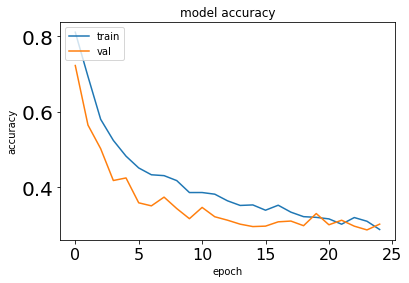

time: 182 ms (started: 2022-12-18 17:18:31 +00:00)


In [41]:
history = h

plt.rcParams["figure.figsize"] = (6,4)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

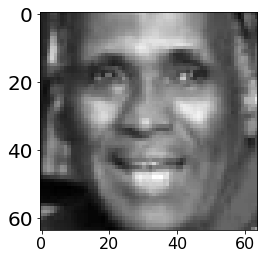

Actual Gender: Male Age: 54
Values: [array([[0.68435633]], dtype=float32), array([[0.33326033]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


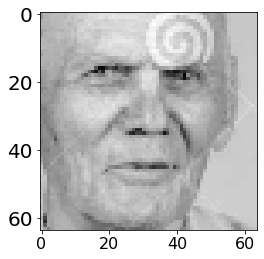

Actual Gender: Male Age: 82
Values: [array([[0.7539723]], dtype=float32), array([[0.05171782]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


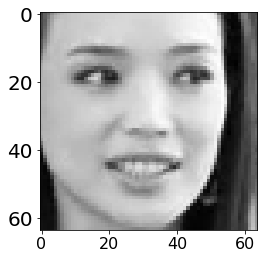

Actual Gender: Female Age: 24
Values: [array([[0.48342294]], dtype=float32), array([[0.9987538]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


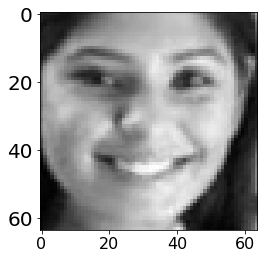

Actual Gender: Female Age: 21
Values: [array([[0.49358386]], dtype=float32), array([[0.97762614]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


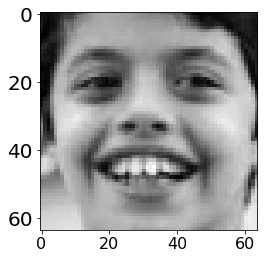

Actual Gender: Male Age: 7
Values: [array([[0.46401832]], dtype=float32), array([[0.05171782]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


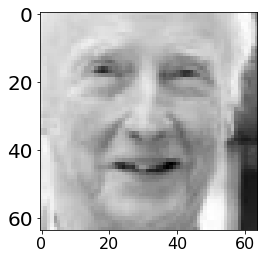

Actual Gender: Male Age: 76
Values: [array([[0.71978813]], dtype=float32), array([[0.07056919]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


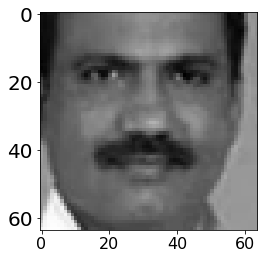

Actual Gender: Male Age: 34
Values: [array([[0.69288146]], dtype=float32), array([[0.05171782]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


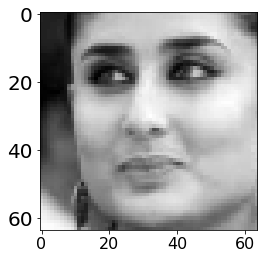

Actual Gender: Female Age: 25
Values: [array([[0.54676026]], dtype=float32), array([[0.99804014]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


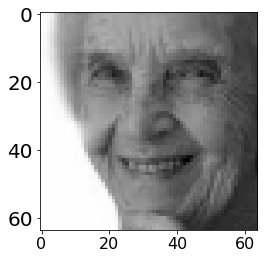

Actual Gender: Female Age: 79
Values: [array([[0.71581304]], dtype=float32), array([[0.9284135]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80
time: 59.6 s (started: 2022-12-18 17:19:05 +00:00)


In [42]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)
    
    
indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)